In [33]:
import os
os.environ['MKL_NUM_THREADS'] = '1'
os.environ['OPENBLAS_NUM_THREADS'] = '1'
import logging
logger = logging.getLogger()
logger.setLevel(logging.WARNING)
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import multiprocessing
import itertools as it
from scipy.special import expit
import pymc3 as pm
import arviz as az
import theano.tensor as tt

In [34]:
import warnings
warnings.simplefilter('ignore')

In [35]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
sns.set()

# Make data

In [36]:
np.random.seed(123)

In [37]:
def u(x, alpha):
    return x**(1 - alpha)

def f_choice(x, tau):
    return expit(x*(1/tau))

In [38]:
# steps = np.linspace(0.01,0.99, 10)
# task = pd.DataFrame(np.array(list(it.product(steps, repeat=4))), columns=["p0", "x0", "p1", "x1"])
task = pd.DataFrame(np.random.random(size=(1000, 4)), columns=["p0", "x0", "p1", "x1"])
task = task[~((task.p0 >= task.p1) & (task.x0 >= task.x1))]
task = task[~((task.p1 >= task.p0) & (task.x1 >= task.x0))]

In [39]:
n_trial = len(task)

true_tau = 0.3 # 3.33 # 0.1
true_alpha = 0.4

seu0 = task.p0 * u(task.x0, true_alpha)
seu1 = task.p1 * u(task.x1, true_alpha)

diff_eu = seu1 - seu0
task['diff_eu'] = diff_eu

p_choice_1 = f_choice(diff_eu, true_tau)

choice = np.zeros(n_trial, dtype=int)
choice[:] = p_choice_1 > np.random.random(size=n_trial)
task["choice"] = choice

n = 100
task = task.sample(n=n, replace=False)
task = task.sort_values(by="diff_eu")
task.reset_index(inplace=True, drop=True)
task

,p0,x0,p1,x1,diff_eu,choice
0,0.610272,0.911365,0.060995,0.991708,-0.516526,0
1,0.931932,0.582175,0.206096,0.717758,-0.504712,0
2,0.769397,0.573774,0.102635,0.699834,-0.468459,0
3,0.782821,0.558396,0.133484,0.829552,-0.432533,0
4,0.654901,0.596849,0.072152,0.632890,-0.425668,1
...,...,...,...,...,...,...
95,0.729661,0.157371,0.692422,0.730335,0.332846,1
96,0.166744,0.828984,0.912390,0.391699,0.370941,0
97,0.020576,0.918097,0.864480,0.276902,0.380536,0
98,0.129865,0.859377,0.571432,0.836710,0.394886,1


# How does it look like

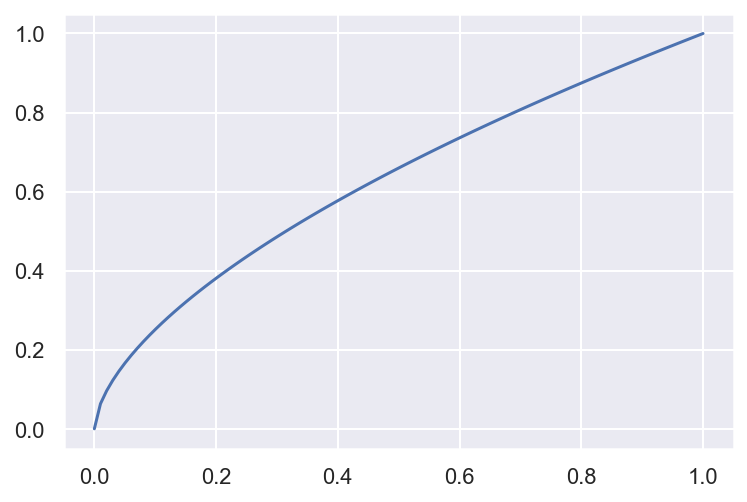

In [40]:
x_plot = np.linspace(0, 1, 100)
plt.plot(x_plot, u(x_plot, true_alpha))

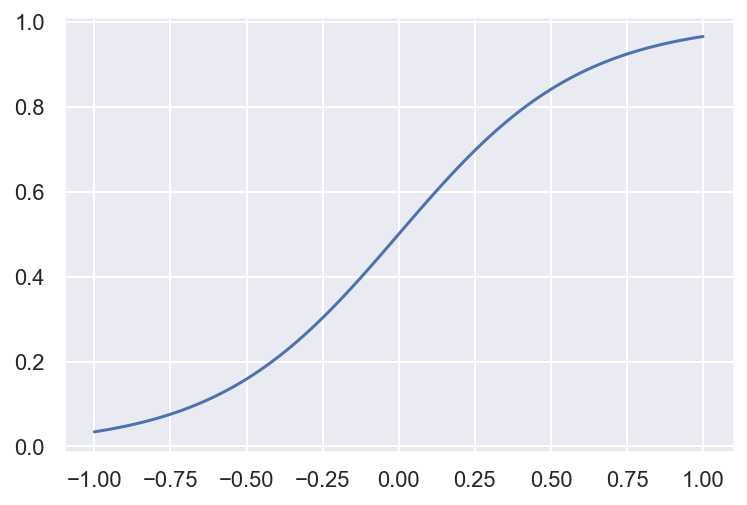

In [41]:
x_plot = np.linspace(-1, 1, 100)
plt.plot(x_plot, f_choice(x_plot, true_tau))

In [43]:
p0 = task.p0.values
p1 = task.p1.values
x0 = task.x0.values
x1 = task.x1.values
y = task.choice.values
diff_eu = task.diff_eu.values

x = np.hstack((x0, x1))
p = np.hstack((p0, p1))
x_order = np.argsort(x)
x_sorted = x[x_order]
undo_sorted = np.argsort(x_order)

u_sorted = u(x_sorted, true_alpha)
p_sorted = p[x_order]
eu_sorted = p_sorted*u_sorted
p_choice1 = f_choice(diff_eu, true_tau)

print(len(x_sorted))
print(n)

200
100


# Model Discrepancy

## Assuming alpha is NOT known

In [63]:
with pm.Model() as model:

    ρ = pm.InverseGamma('ρ', 2, 2)
    η = pm.HalfCauchy('η', 5)
    
    α = pm.TruncatedNormal('α', 1, 1000, lower=-1)
    
    X = x_sorted.reshape(-1, 1)
    uX = u(X, alpha=α)
    
    M = pm.gp.mean.Constant(uX.flatten())
    K = tt.dot(uX, uX.T) * η**2 * pm.gp.cov.ExpQuad(1, ρ)
    
    gp = pm.gp.Latent(mean_func=M, cov_func=K)
    
    # Place a GP prior over the function f.
    f = gp.prior("f", X=X)

    est_eu =  p_sorted * f    
    est_eu_unsorted = est_eu[undo_sorted]
    
    diff_eu_hat = pm.Deterministic("diff_eu_hat", est_eu_unsorted[n:] - est_eu_unsorted[:n])
    
    tau_hat = true_tau
    est_p_choice1 = pm.Deterministic('est_p_choice1', pm.math.invlogit((1/tau_hat)*diff_eu_hat))
    choose_1 = pm.Bernoulli('choose_1', p=est_p_choice1, observed=y)

### Map

In [64]:
with model:
    mp = pm.find_MAP()

array([[<AxesSubplot:title={'center':'ρ_log__'}>,
        <AxesSubplot:title={'center':'ρ_log__'}>],
       [<AxesSubplot:title={'center':'η_log__'}>,
        <AxesSubplot:title={'center':'η_log__'}>],
       [<AxesSubplot:title={'center':'α_lowerbound__'}>,
        <AxesSubplot:title={'center':'α_lowerbound__'}>],
       [<AxesSubplot:title={'center':'f_rotated_'}>,
        <AxesSubplot:title={'center':'f_rotated_'}>],
       [<AxesSubplot:title={'center':'ρ'}>,
        <AxesSubplot:title={'center':'ρ'}>],
       [<AxesSubplot:title={'center':'η'}>,
        <AxesSubplot:title={'center':'η'}>],
       [<AxesSubplot:title={'center':'α'}>,
        <AxesSubplot:title={'center':'α'}>],
       [<AxesSubplot:title={'center':'f'}>,
        <AxesSubplot:title={'center':'f'}>],
       [<AxesSubplot:title={'center':'diff_eu_hat'}>,
        <AxesSubplot:title={'center':'diff_eu_hat'}>],
       [<AxesSubplot:title={'center':'est_p_choice1'}>,
        <AxesSubplot:title={'center':'est_p_choice1'}>]

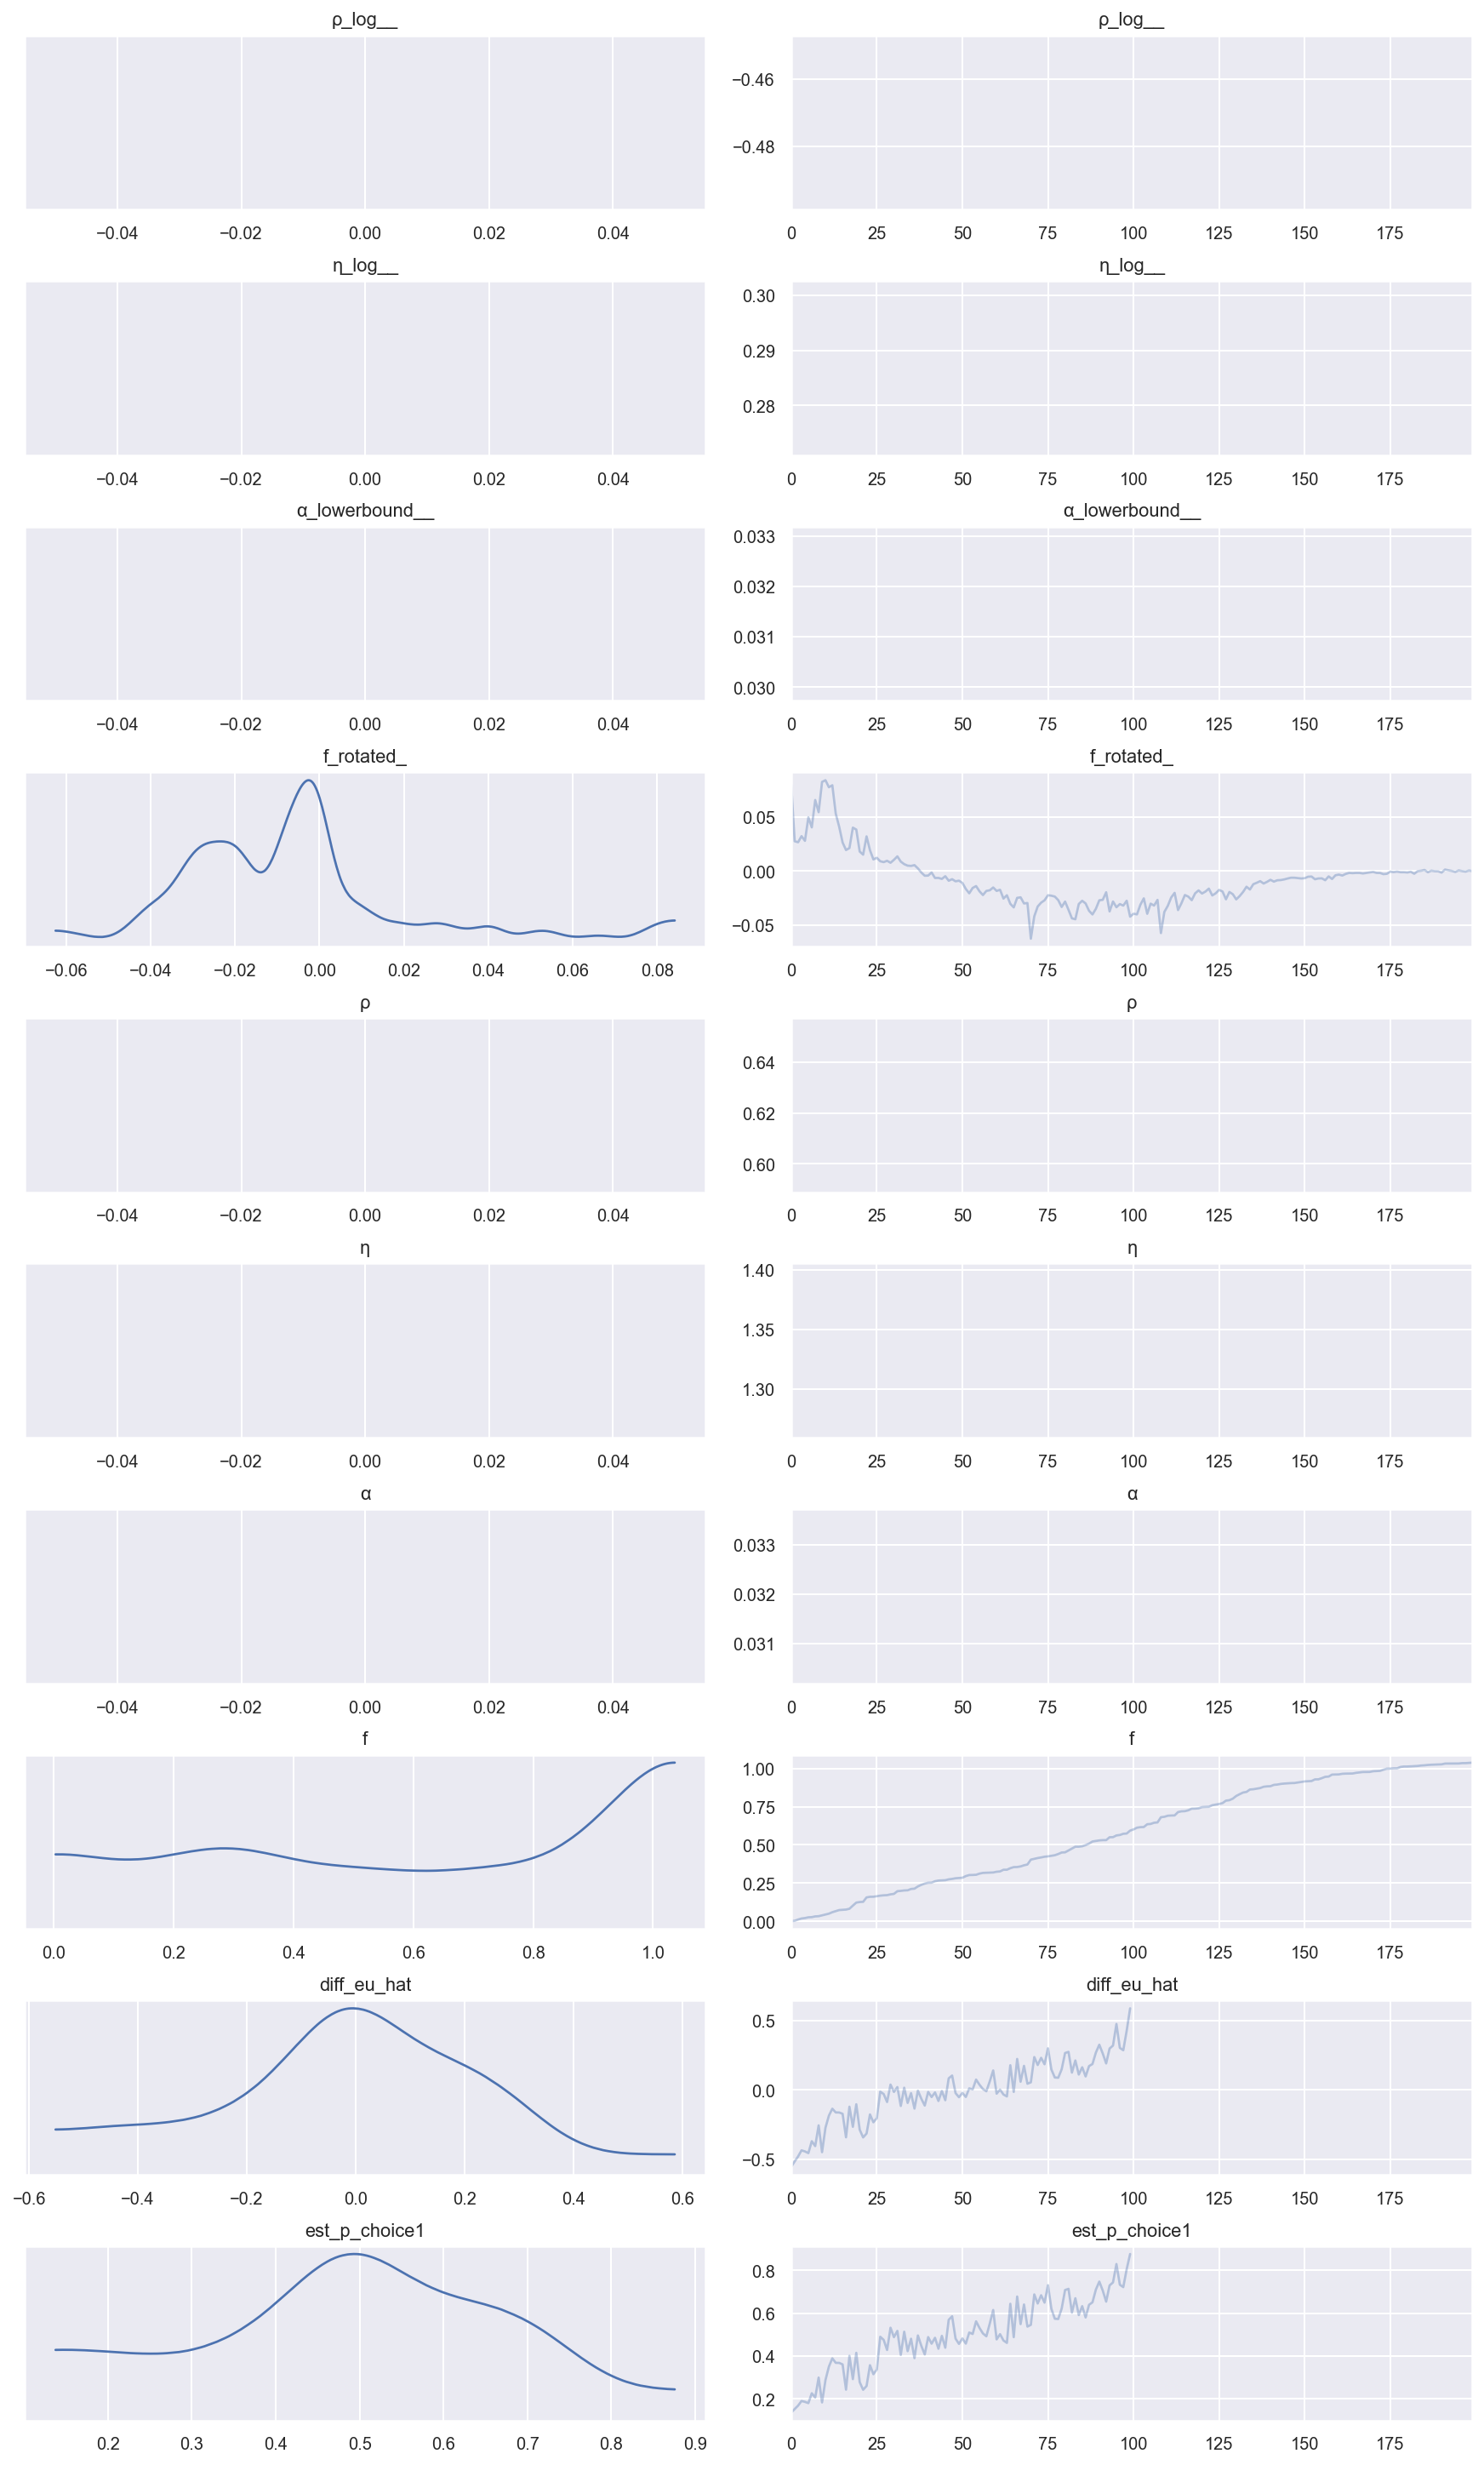

In [67]:
az.plot_trace(mp)

### MCMC

In [69]:
with pm.Model() as model:

    ρ = pm.InverseGamma('ρ', 2, 2)
    η = pm.HalfCauchy('η', 5)
    
    α = pm.TruncatedNormal('α', 1, 1000, lower=-1)
    
    X = x_sorted.reshape(-1, 1)
    uX = u(X, alpha=α)
    
    M = pm.gp.mean.Constant(uX.flatten())
    K = tt.dot(uX, uX.T) * η**2 * pm.gp.cov.ExpQuad(1, ρ)
    
    gp = pm.gp.Latent(mean_func=M, cov_func=K)
    
    # Place a GP prior over the function f.
    f = gp.prior("f", X=X)

    est_eu =  p_sorted * f    
    est_eu_unsorted = est_eu[undo_sorted]
    
    diff_eu_hat = pm.Deterministic("diff_eu_hat", est_eu_unsorted[n:] - est_eu_unsorted[:n])
    
    tau_hat = true_tau
    est_p_choice1 = pm.Deterministic('est_p_choice1', pm.math.invlogit((1/tau_hat)*diff_eu_hat))
    choose_1 = pm.Bernoulli('choose_1', p=est_p_choice1, observed=y)

In [70]:
with model:
    trace = pm.sample(1000, tune=1000, chains=2, return_inferencedata=True, 
                  target_accept=0.90)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [f_rotated_, α, η, ρ]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 315 seconds.
There were 71 divergences after tuning. Increase `target_accept` or reparameterize.
There were 179 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6563254247446096, but should be close to 0.9. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.


<AxesSubplot:>

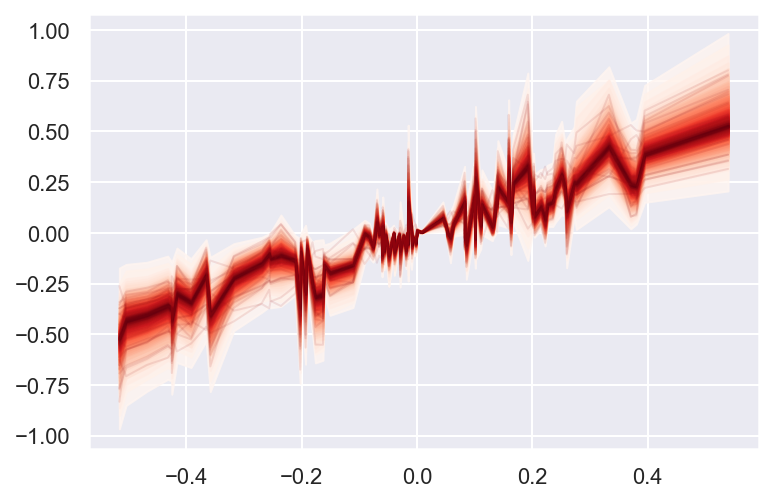

In [71]:
fig, ax = plt.subplots()
# ax.plot(trace['diff_eu_hat', 0, 0].T, 'r', alpha=.03)
pm.gp.util.plot_gp_dist(ax, trace.posterior["diff_eu_hat"][0, :, :], diff_eu)

<AxesSubplot:>

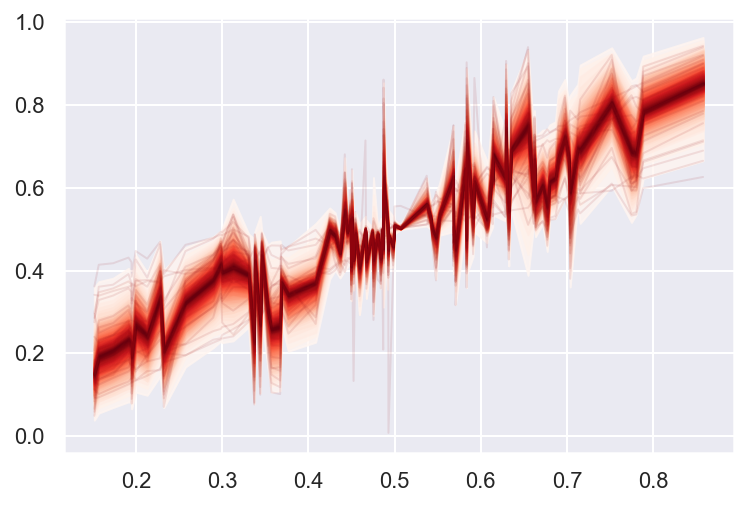

In [72]:
fig, ax = plt.subplots()
pm.gp.util.plot_gp_dist(ax, trace.posterior["est_p_choice1"][0, :, :], p_choice1)

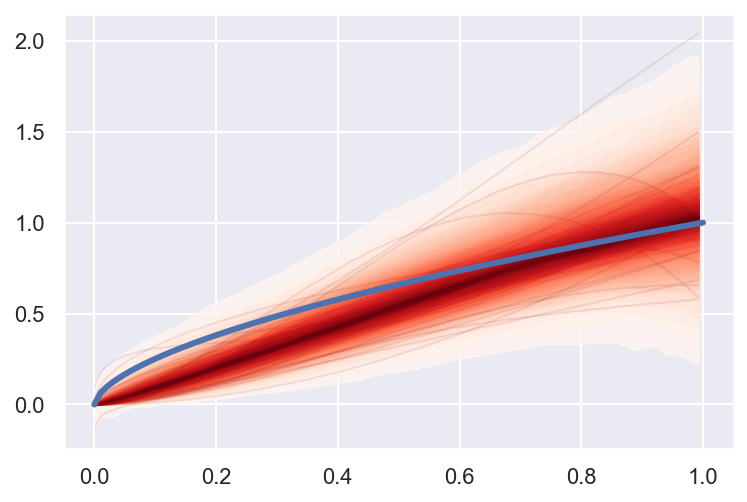

In [73]:
fig, ax = plt.subplots()
pm.gp.util.plot_gp_dist(ax, trace.posterior["f"][0, :, :], x_sorted)

x_plot = np.linspace(0, 1, 100)
# ax.scatter(x_sorted, u(x_sorted, alpha=true_alpha), color='b', alpha=0.2)
ax.plot(x_plot, u(x_plot, alpha=true_alpha), lw=3)

array([<AxesSubplot:title={'center':'ρ'}>,
       <AxesSubplot:title={'center':'η'}>,
       <AxesSubplot:title={'center':'α'}>], dtype=object)

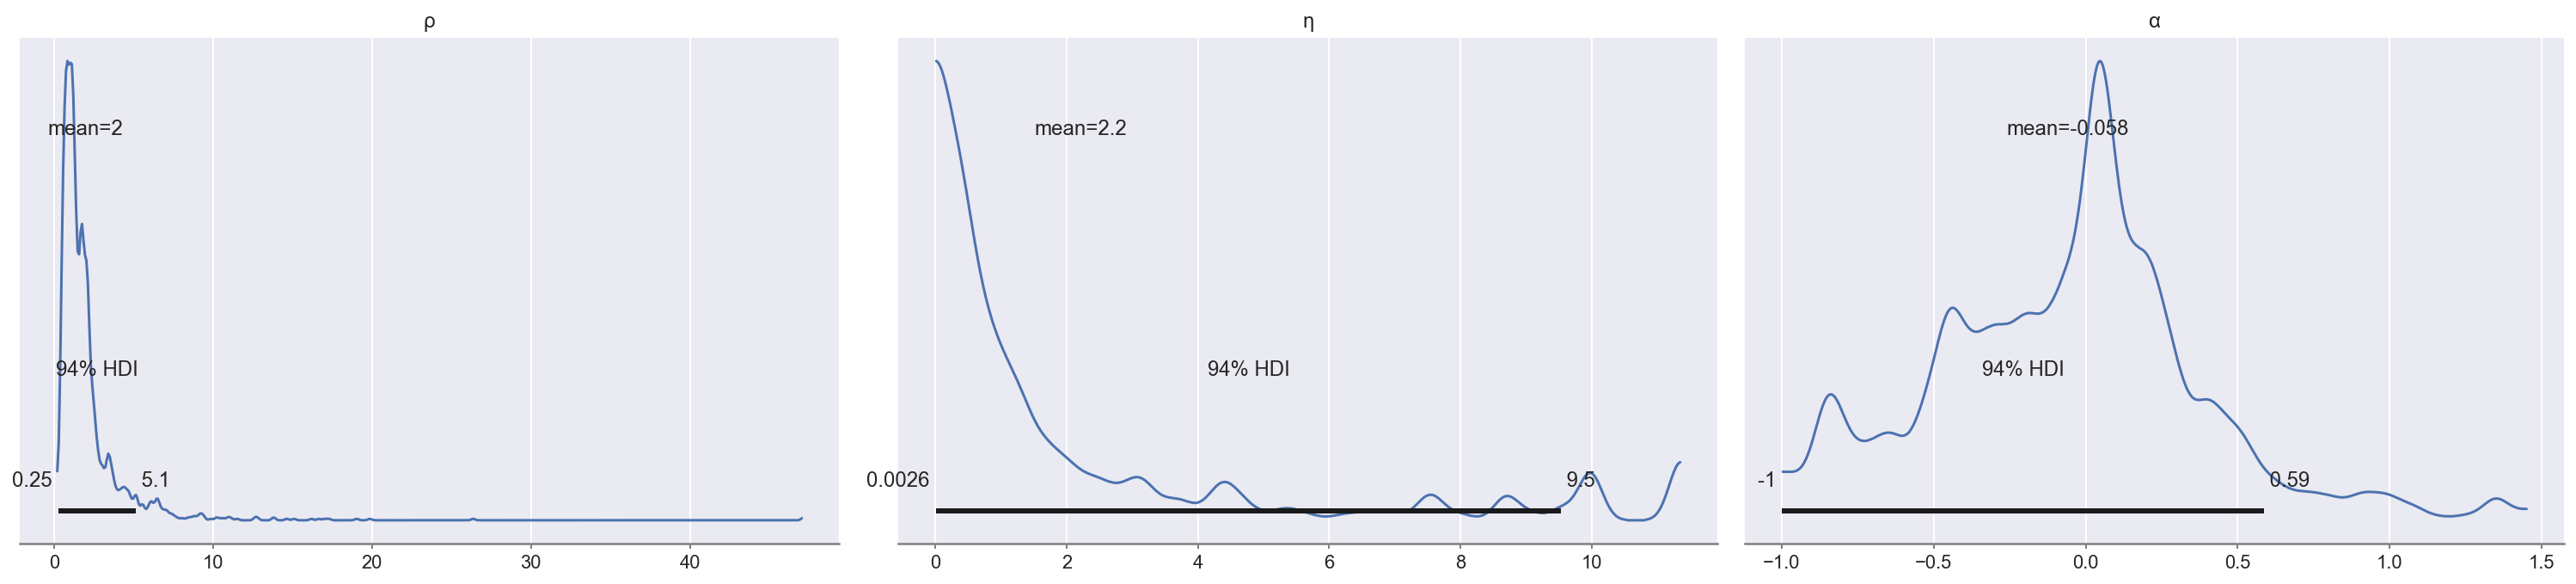

In [74]:
az.plot_posterior(trace, var_names=['ρ', 'η', 'α'])

## Assuming alpha is known

In [75]:
with pm.Model() as model:

    ρ = pm.InverseGamma('ρ', 2, 2)
    η = pm.HalfCauchy('η', 5)
    
    X = x_sorted.reshape(-1, 1)
    uX = u(X, alpha=true_alpha)
    
    M = pm.gp.mean.Constant(uX.flatten())
    K = tt.dot(uX, uX.T) * η**2 * pm.gp.cov.ExpQuad(1, ρ)
    
    gp = pm.gp.Latent(mean_func=M, cov_func=K)
    
    # Place a GP prior over the function f.
    f = gp.prior("f", X=X)

    est_eu =  p_sorted * f    
    est_eu_unsorted = est_eu[undo_sorted]
    
    diff_eu_hat = pm.Deterministic("diff_eu_hat", est_eu_unsorted[n:] - est_eu_unsorted[:n])
    
    tau_hat = true_tau
    est_p_choice1 = pm.Deterministic('est_p_choice1', pm.math.invlogit((1/tau_hat)*diff_eu_hat))
    choose_1 = pm.Bernoulli('choose_1', p=est_p_choice1, observed=y)

### Map

In [76]:
with model:
    mp = pm.find_MAP()

array([[<AxesSubplot:title={'center':'ρ_log__'}>,
        <AxesSubplot:title={'center':'ρ_log__'}>],
       [<AxesSubplot:title={'center':'η_log__'}>,
        <AxesSubplot:title={'center':'η_log__'}>],
       [<AxesSubplot:title={'center':'f_rotated_'}>,
        <AxesSubplot:title={'center':'f_rotated_'}>],
       [<AxesSubplot:title={'center':'ρ'}>,
        <AxesSubplot:title={'center':'ρ'}>],
       [<AxesSubplot:title={'center':'η'}>,
        <AxesSubplot:title={'center':'η'}>],
       [<AxesSubplot:title={'center':'f'}>,
        <AxesSubplot:title={'center':'f'}>],
       [<AxesSubplot:title={'center':'diff_eu_hat'}>,
        <AxesSubplot:title={'center':'diff_eu_hat'}>],
       [<AxesSubplot:title={'center':'est_p_choice1'}>,
        <AxesSubplot:title={'center':'est_p_choice1'}>]], dtype=object)

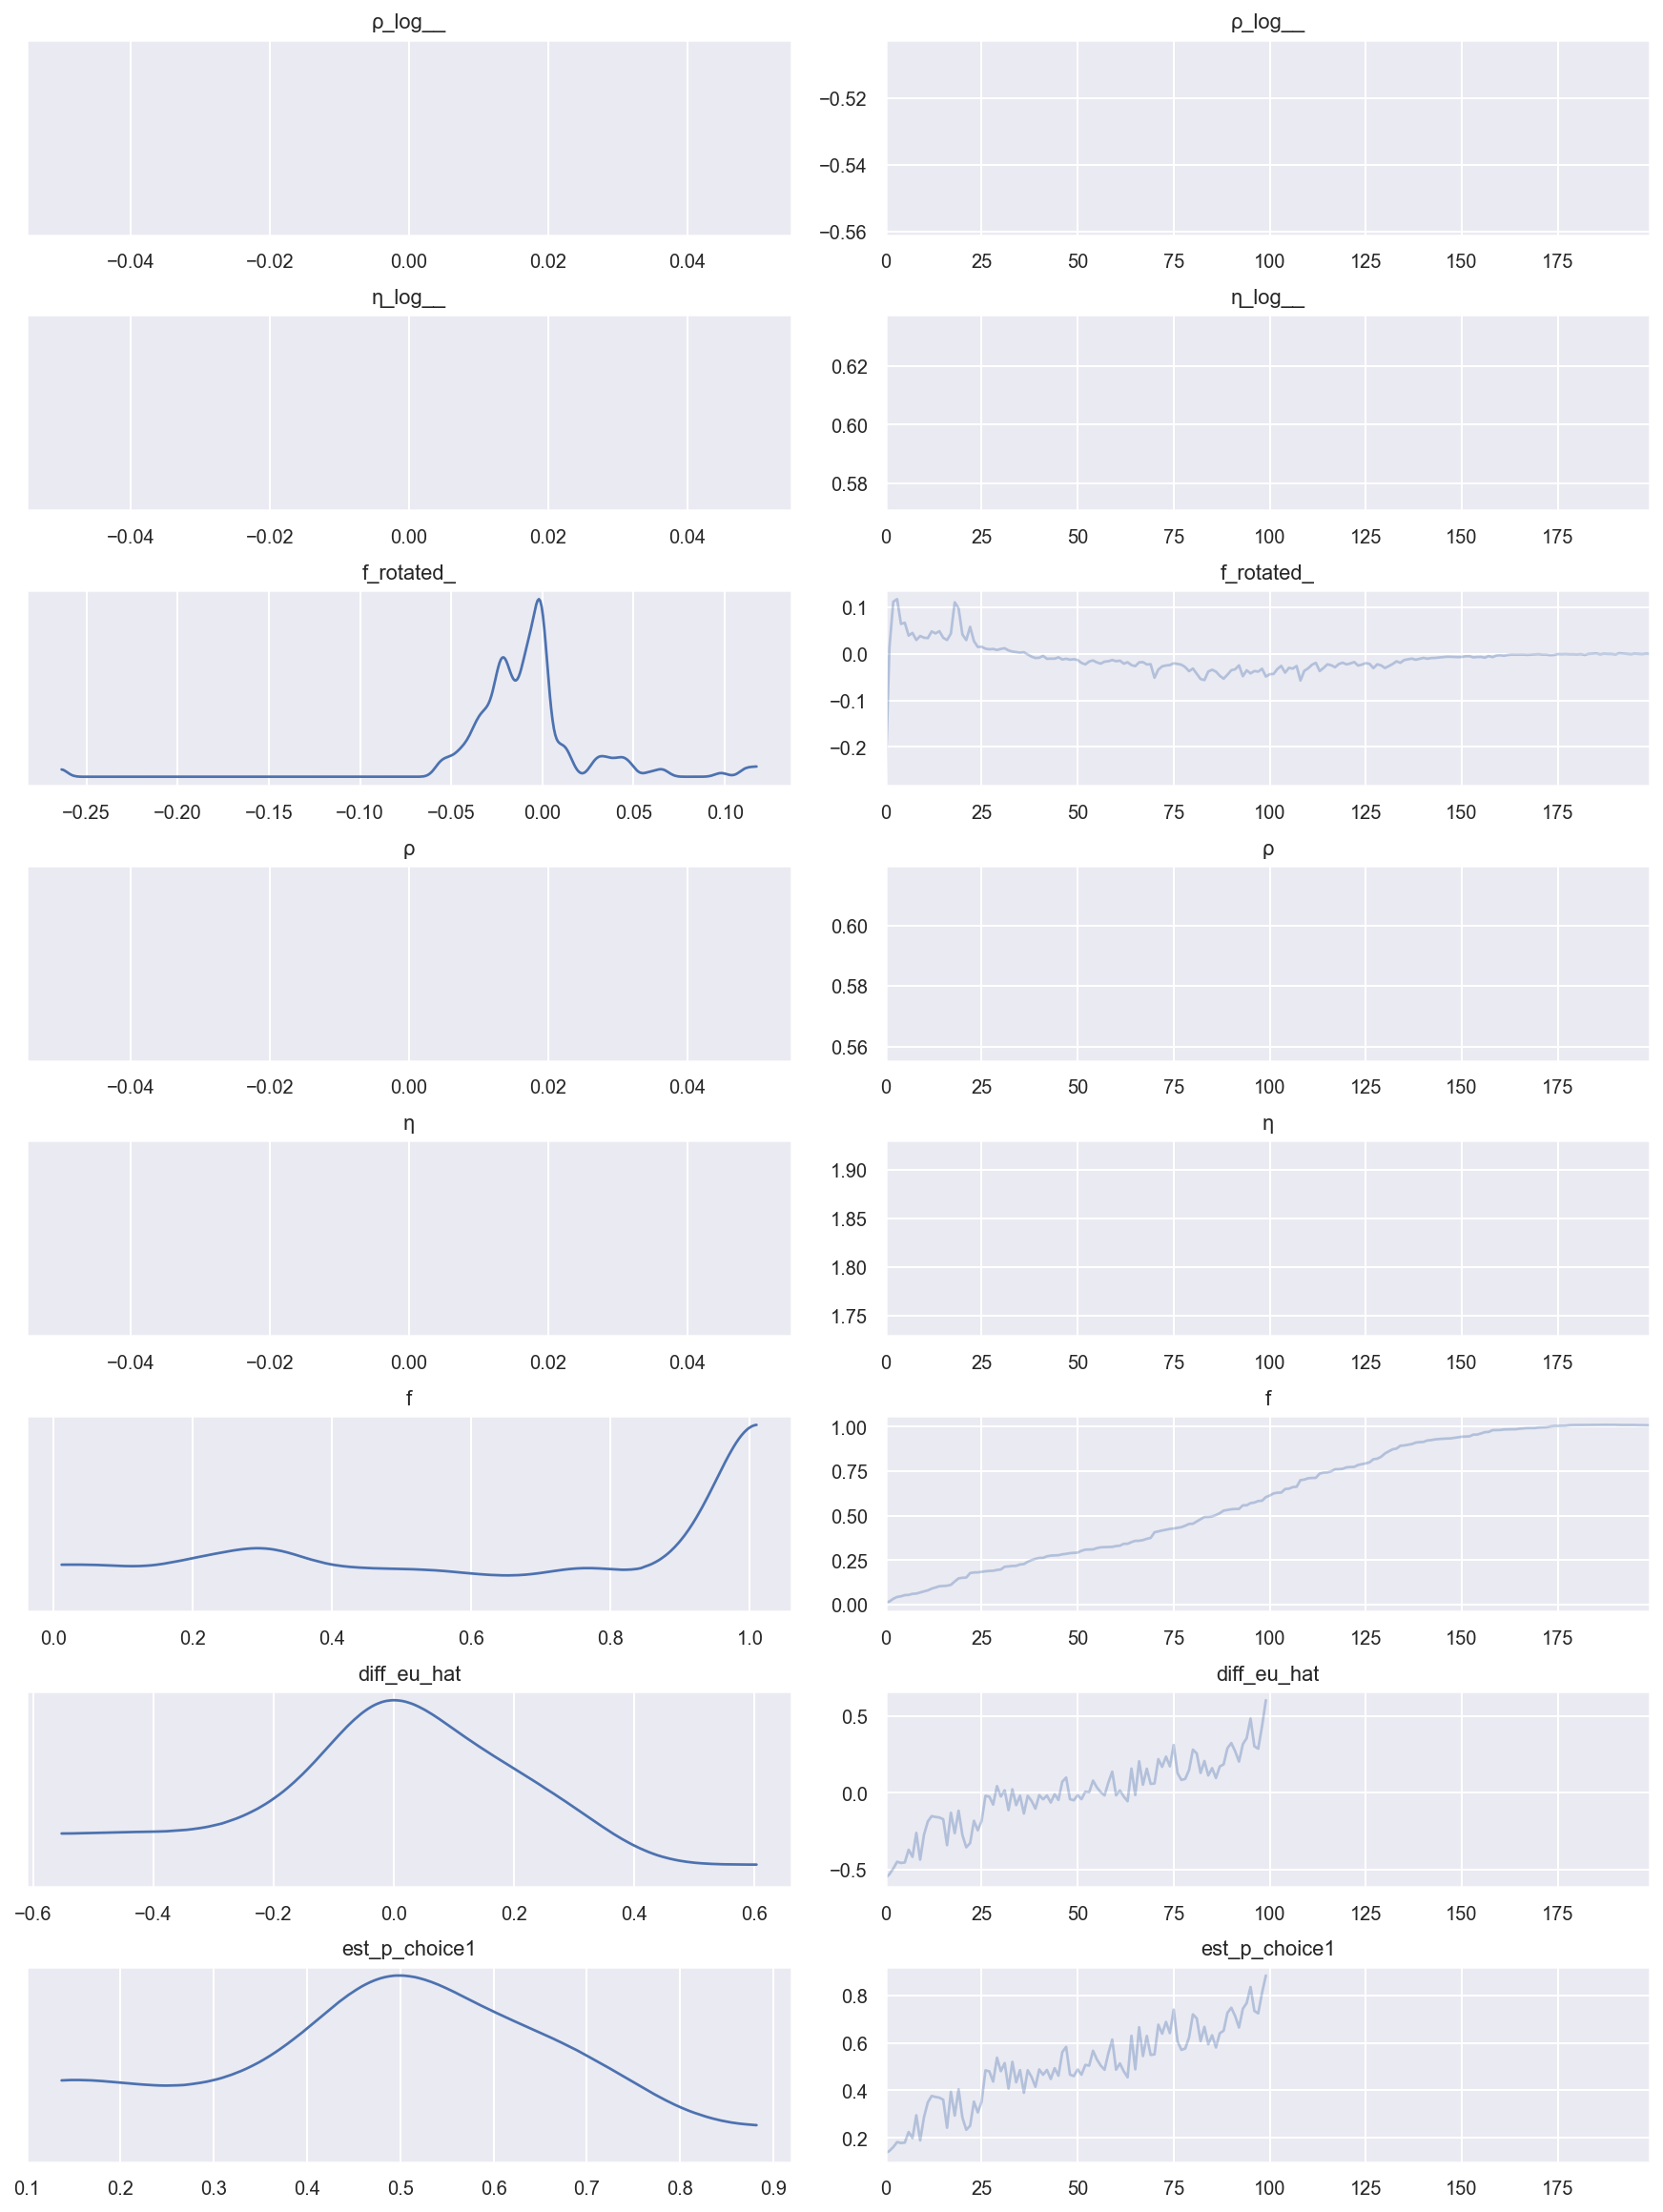

In [77]:
az.plot_trace(mp)

### MCMC

In [84]:
with pm.Model() as model:

    ρ = pm.InverseGamma('ρ', 2, 2)
    η = pm.HalfCauchy('η', 5)
    
    X = x_sorted.reshape(-1, 1)
    uX = u(X, alpha=true_alpha)
    
    M = pm.gp.mean.Constant(uX.flatten())
    K = tt.dot(uX, uX.T) * η**2 * pm.gp.cov.ExpQuad(1, ρ)
    
    gp = pm.gp.Latent(mean_func=M, cov_func=K)
    
    # Place a GP prior over the function f.
    f = gp.prior("f", X=X)

    est_eu =  p_sorted * f    
    est_eu_unsorted = est_eu[undo_sorted]
    
    diff_eu_hat = pm.Deterministic("diff_eu_hat", est_eu_unsorted[n:] - est_eu_unsorted[:n])
    
    tau_hat = true_tau
    est_p_choice1 = pm.Deterministic('est_p_choice1', pm.math.invlogit((1/tau_hat)*diff_eu_hat))
    choose_1 = pm.Bernoulli('choose_1', p=est_p_choice1, observed=y)

In [85]:
with model:
    trace = pm.sample(1000, tune=1000, chains=2, return_inferencedata=True, 
                  target_accept=0.90)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [f_rotated_, η, ρ]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 181 seconds.
There were 17 divergences after tuning. Increase `target_accept` or reparameterize.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.


<AxesSubplot:>

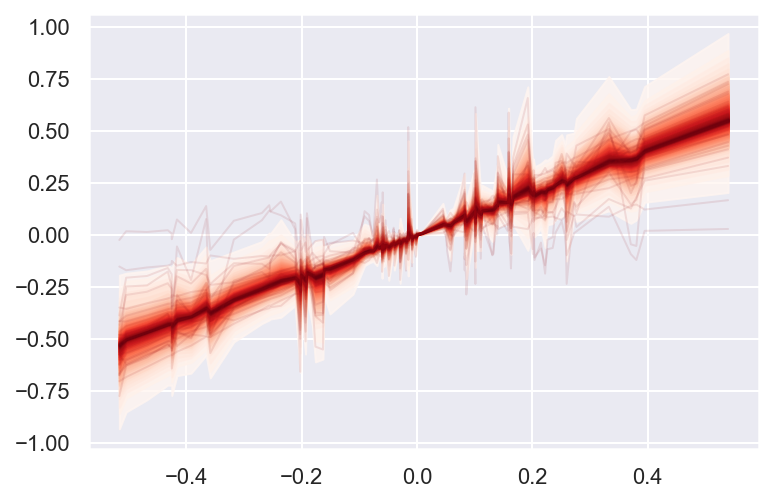

In [86]:
fig, ax = plt.subplots()
# ax.plot(trace['diff_eu_hat', 0, 0].T, 'r', alpha=.03)
pm.gp.util.plot_gp_dist(ax, trace.posterior["diff_eu_hat"][0, :, :], diff_eu)

<AxesSubplot:>

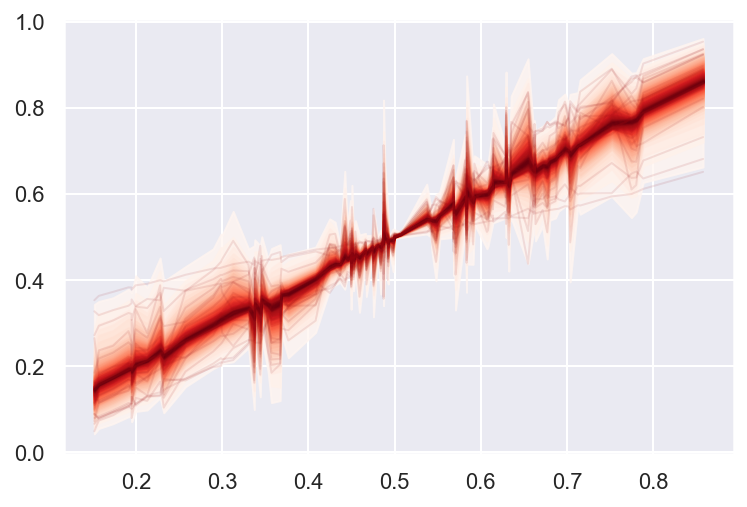

In [87]:
fig, ax = plt.subplots()
pm.gp.util.plot_gp_dist(ax, trace.posterior["est_p_choice1"][0, :, :], p_choice1)

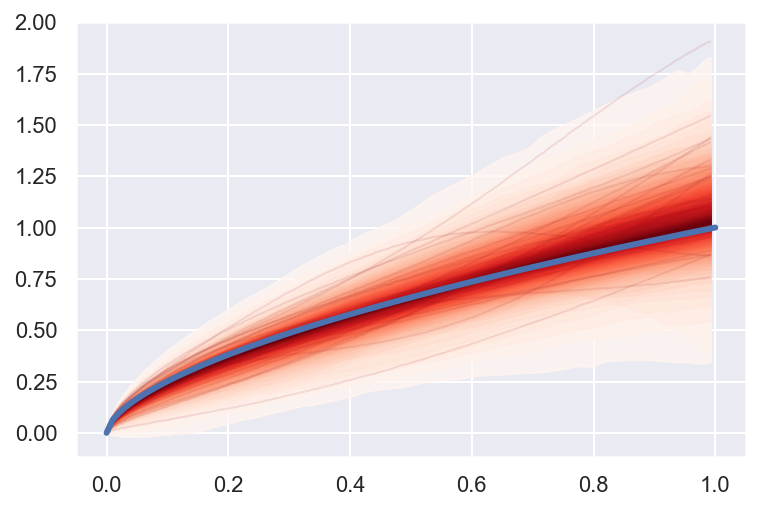

In [88]:
fig, ax = plt.subplots()
pm.gp.util.plot_gp_dist(ax, trace.posterior["f"][0, :, :], x_sorted)

x_plot = np.linspace(0, 1, 100)
# ax.scatter(x_sorted, u(x_sorted, alpha=true_alpha), color='b', alpha=0.2)
ax.plot(x_plot, u(x_plot, alpha=true_alpha), lw=3)

array([<AxesSubplot:title={'center':'ρ'}>,
       <AxesSubplot:title={'center':'η'}>], dtype=object)

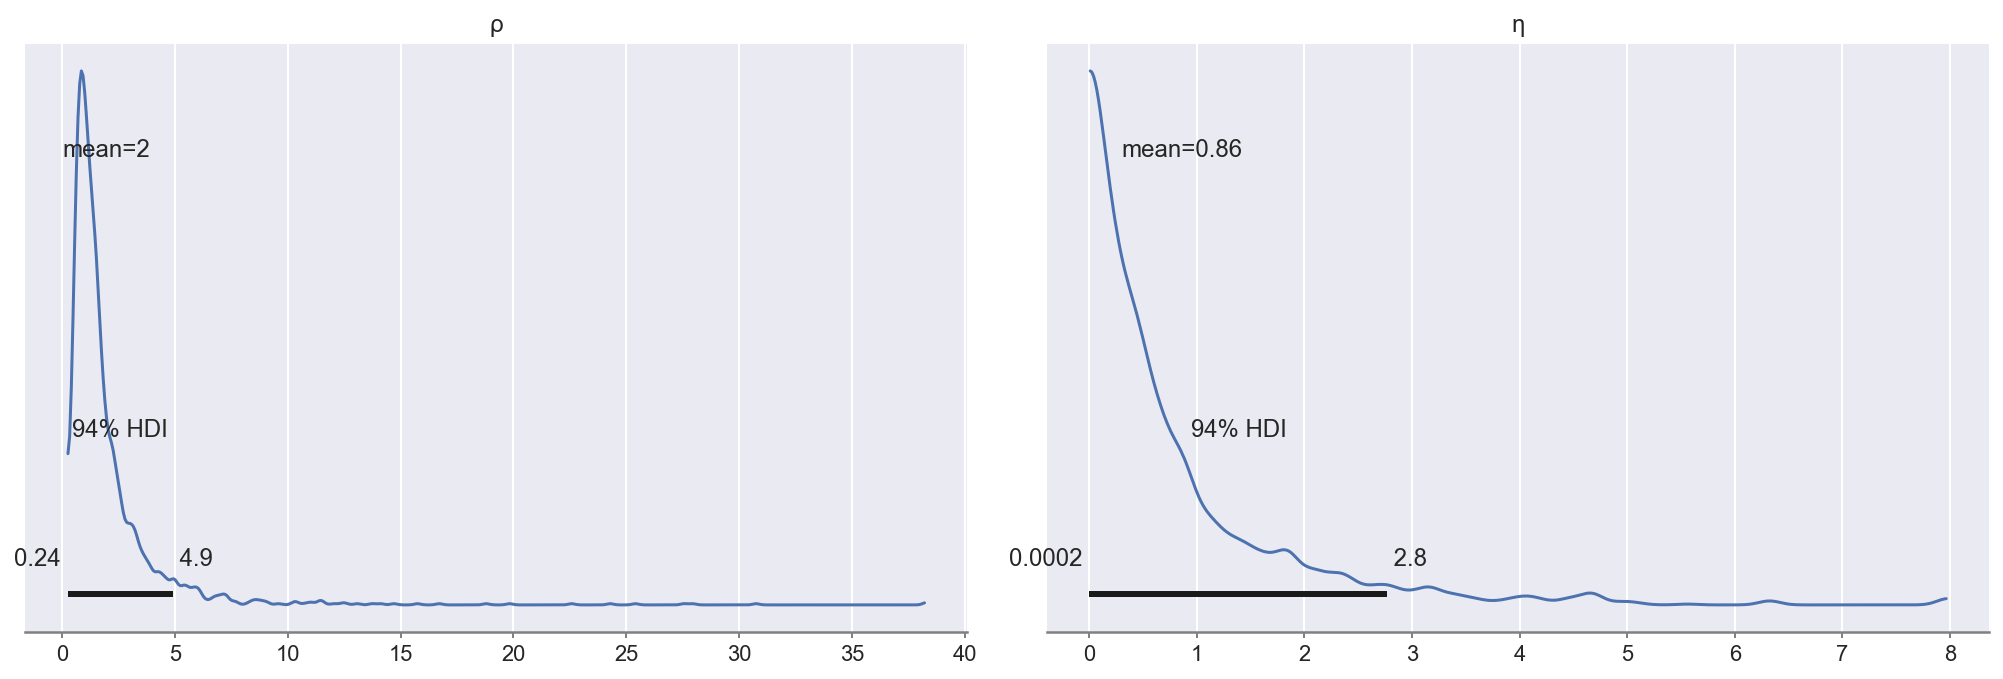

In [90]:
az.plot_posterior(trace, var_names=['ρ', 'η',])